# Revisiting BG/NBD

Replacing BART component with BG/NBD with time-varying covariates

Findings
- very slow in processing - backtesting is not feasible / very time consuming (~30 minutes for each cutoff)
- based on a single test, the predicted 3 and 6 months forward revenue count does not capture the observed number of purchases.

## Set Up

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import graphviz
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import xarray as xr
import seaborn as sns
import pandas as pd

import pymc as pm 
import pymc_bart as pmb
import pytensor
import pytensor.tensor as pt

from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_percentage_error
)
from lifetimes import BetaGeoFitter
from warnings import filterwarnings
from scipy.special import expit, hyp2f1
filterwarnings("ignore", category=UserWarning, module="pymc")

import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import project_utils


In [2]:
transactions = project_utils.load_transactions('../transactions.csv')
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00
...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00


In [3]:
transactions = project_utils.preprocess_transactions(transactions)
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01
...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01


In [4]:
def _find_first_transactions(
    transactions: pd.DataFrame,
    customer_id_col: str,
    datetime_col: str,
    monetary_value_col: str | None = None,
    datetime_format: str | None = None,
    observation_period_end: str | pd.Period | datetime | None = None,
    time_unit: str = "D",
    sort_transactions: bool | None = True,
) -> pd.DataFrame:
    """Return dataframe with first transactions.

    This takes a DataFrame of transaction data of the form:
        *customer_id, datetime [, monetary_value]*
    and appends a column named *repeated* to the transaction log to indicate which rows
    are repeated transactions for each *customer_id*.

    Adapted from lifetimes package
    https://github.com/CamDavidsonPilon/lifetimes/blob/41e394923ad72b17b5da93e88cfabab43f51abe2/lifetimes/utils.py#L148

    Parameters
    ----------
    transactions : ~pd.DataFrame
        A pd DataFrame containing *customer_id_col* and *datetime_col*.
    customer_id_col : string
        Column in the *transactions* DataFrame denoting the *customer_id*.
    datetime_col :  string
        Column in the *transactions* DataFrame denoting datetimes purchase were made.
    monetary_value_col : string, optional
        Column in the *transactions* DataFrame that denotes the monetary value of the transaction.
        Optional; only needed for spend estimation models like the Gamma-Gamma model.
    datetime_format : string, optional
        A string that represents the timestamp format. Useful if pd can't understand
        the provided format.
    observation_period_end : Union[str, pd.Period, datetime], optional
        A string or datetime to denote the final date of the study.
        Events after this date are truncated. If not given, defaults to the max 'datetime_col'.
    time_unit : string, optional
        Time granularity for study.
        Default : 'D' for days. Possible values listed here:
        https://numpy.org/devdocs/reference/arrays.datetime.html#datetime-units
    sort_transactions : bool, optional
        Default: True
        If raw data is already sorted in chronological order, set to `False` to improve computational efficiency.

    """
    select_columns = [customer_id_col, datetime_col]

    if observation_period_end is None:
        observation_period_end = transactions[datetime_col].max()

    if isinstance(observation_period_end, pd.Period):
        observation_period_end = observation_period_end.to_timestamp()
    if isinstance(observation_period_end, str):
        observation_period_end = pd.to_datetime(observation_period_end)

    if monetary_value_col:
        select_columns.append(monetary_value_col)

    if sort_transactions:
        transactions = transactions[select_columns].sort_values(select_columns).copy()

    # convert date column into a DateTimeIndex for time-wise grouping and truncating
    transactions[datetime_col] = pd.to_datetime(
        transactions[datetime_col], format=datetime_format
    )
    transactions = (
        transactions.set_index(datetime_col).to_period(time_unit).to_timestamp()
    )

    mask = pd.to_datetime(transactions.index) <= pd.to_datetime(
        observation_period_end
    )

    transactions = transactions.loc[mask].reset_index()

    period_groupby = transactions.groupby(
        [datetime_col, customer_id_col], sort=False, as_index=False
    )

    if monetary_value_col:
        # when processing a monetary column, make sure to sum together transactions made in the same period
        period_transactions = period_groupby.sum()
    else:
        # by calling head() on the groupby object, the datetime and customer_id columns
        # will be reduced to the first transaction of that time period
        period_transactions = period_groupby.head(1)

    # create a new column for flagging first transactions
    period_transactions = period_transactions.copy()
    period_transactions.loc[:, "first"] = False
    # find all first transactions and store as an index
    first_transactions = (
        period_transactions.groupby(customer_id_col, sort=True, as_index=False)
        .head(1)
        .index
    )
    # flag first transactions as True
    period_transactions.loc[first_transactions, "first"] = True
    select_columns.append("first")
    # reset datetime_col to period
    period_transactions[datetime_col] = period_transactions[datetime_col].dt.to_period(
        time_unit
    )

    return period_transactions[select_columns]
def rfm_summary(
    transactions: pd.DataFrame,
    customer_id_col: str,
    datetime_col: str,
    monetary_value_col: str | None = None,
    datetime_format: str | None = None,
    observation_period_end: str | pd.Period | datetime | None = None,
    time_unit: str = "D",
    time_scaler: float | None = 1,
    include_first_transaction: bool | None = False,
    sort_transactions: bool | None = True,
) -> pd.DataFrame:
    """Summarize transaction data for use in CLV modeling or RFM segmentation.

    This transforms a DataFrame of transaction data of the form:
        *customer_id, datetime [, monetary_value]*
    to a DataFrame for CLV modeling:
        *customer_id, frequency, recency, T [, monetary_value]*

    If the `include_first_transaction = True` argument is specified, a DataFrame for RFM segmentation is returned:
        *customer_id, frequency, recency, monetary_value*

    This function is not required if using the `clv.rfm_segments` utility.

    Adapted from lifetimes package
    https://github.com/CamDavidsonPilon/lifetimes/blob/41e394923ad72b17b5da93e88cfabab43f51abe2/lifetimes/utils.py#L230

    Parameters
    ----------
    transactions : ~pd.DataFrame
        A pd DataFrame containing *customer_id_col* and *datetime_col*.
    customer_id_col : string
        Column in the *transactions* DataFrame denoting the *customer_id*.
    datetime_col :  string
        Column in the *transactions* DataFrame denoting datetimes purchase were made.
    monetary_value_col : string, optional
        Column in the transactions DataFrame denoting the monetary value of the transaction.
        Optional; only needed for RFM segmentation and spend estimation models like the Gamma-Gamma model.
    observation_period_end : Union[str, pd.Period, datetime], optional
        A string or datetime to denote the final date of the study.
        Events after this date are truncated. If not given, defaults to the max 'datetime_col'.
    datetime_format : string, optional
        A string that represents the timestamp format. Useful if pd doesn't recognize the provided format.
    time_unit : string, optional
        Time granularity for study.
        Default: 'D' for days. Possible values listed here:
        https://numpy.org/devdocs/reference/arrays.datetime.html#datetime-units
    time_scaler : int, optional
        Default: 1. Scales *recency* & *T* to a different time granularity.
        This is useful for datasets spanning many years, and running predictions in different time scales.
    datetime_format : string, optional
        A string that represents the timestamp format. Useful if pd doesn't recognize the provided format.
    monetary_value_col : string, optional
        Column in the *transactions* DataFrame that denotes the monetary value of the transaction.
        Optional; only needed for spend estimation models like the Gamma-Gamma model.
    include_first_transaction : bool, optional
        Default: *False*
        For predictive CLV modeling, this should be *False*.
        Set to *True* if performing RFM segmentation.
    sort_transactions : bool, optional
        Default: *True*
        If raw data is already sorted in chronological order, set to *False* to improve computational efficiency.

    Returns
    -------
    DataFrame
        Dataframe containing summarized RFM data, and test columns for *frequency*, *T*,
        and *monetary_value* if specified

    """
    if observation_period_end is None:
        observation_period_end_ts = (
            pd.to_datetime(transactions[datetime_col].max(), format=datetime_format)
            .to_period(time_unit)
            .to_timestamp()
        )
    elif isinstance(observation_period_end, pd.Period):
        observation_period_end_ts = observation_period_end.to_timestamp()
    else:
        observation_period_end_ts = (
            pd.to_datetime(observation_period_end, format=datetime_format)
            .to_period(time_unit)
            .to_timestamp()
        )

    # label repeated transactions
    repeated_transactions = _find_first_transactions(  # type: ignore
        transactions,
        customer_id_col,
        datetime_col,
        monetary_value_col,
        datetime_format,
        observation_period_end_ts,
        time_unit,
        sort_transactions,
    )
    # reset datetime_col to timestamp
    repeated_transactions[datetime_col] = repeated_transactions[
        datetime_col
    ].dt.to_timestamp()

    # count all orders by customer
    customers = repeated_transactions.groupby(customer_id_col, sort=False)[
        datetime_col
    ].agg(["min", "max", "count"])

    # subtract 1 from count, as we ignore the first order.
    customers["frequency"] = customers["count"] - 1

    customers["recency"] = (
        (pd.to_datetime(customers["max"]) - pd.to_datetime(customers["min"]))  # type: ignore
        / np.timedelta64(1, time_unit)
        / time_scaler
    )

    customers["T"] = (
        (observation_period_end_ts - customers["min"])
        / np.timedelta64(1, time_unit)
        / time_scaler
    )

    summary_columns = ["frequency", "recency", "T"]

    if include_first_transaction:
        # add the first order back to the frequency count
        customers["frequency"] = customers["frequency"] + 1

        # change recency to segmentation definition
        customers["recency"] = customers["T"] - customers["recency"]

        # T column is not used for segmentation
        summary_columns = ["frequency", "recency"]

    if monetary_value_col:
        if not include_first_transaction:
            # create an index of all the first purchases
            first_purchases = repeated_transactions[
                repeated_transactions["first"]
            ].index
            # by setting the monetary_value cells of all the first purchases to NaN,
            # those values will be excluded from the mean value calculation
            repeated_transactions.loc[first_purchases, monetary_value_col] = np.nan
        customers["monetary_value"] = (
            repeated_transactions.groupby(customer_id_col)[monetary_value_col]
            .mean()
            .fillna(0)
        )
        summary_columns.append("monetary_value")

    summary_df = customers[summary_columns].astype(float)
    summary_df = summary_df.reset_index().rename(
        columns={customer_id_col: "customer_id"}
    )

    return summary_df

## Initial attempt

In [5]:
rfm = rfm_summary(
    transactions,
    customer_id_col="CUSTOMER_KEY",
    datetime_col="DATE_KEY",
    monetary_value_col="FULL_REVENUE",
    time_unit = "D",
)

rfm

,customer_id,frequency,recency,T,monetary_value
0,1.01691637690413e+19,0.0,0.0,1074.0,0.000000
1,1.0180262201447422e+19,0.0,0.0,1060.0,0.000000
2,1.0334292439570778e+19,0.0,0.0,851.0,0.000000
3,1.1021537414442353e+19,0.0,0.0,681.0,0.000000
4,1.1460252927270205e+19,0.0,0.0,1103.0,0.000000
...,...,...,...,...,...
206238,997118640185.0,1.0,557.0,1180.0,90.000000
206239,997525913657.0,0.0,0.0,1057.0,0.000000
206240,998212173881.0,2.0,1079.0,1117.0,0.000000
206241,998809370681.0,2.0,688.0,690.0,226.565000


In [6]:
n = rfm.shape[0]
x = rfm['frequency'].to_numpy()
t_x = rfm['recency'].to_numpy()
T = rfm['T'].to_numpy()

int_vec = np.vectorize(int)
x_zero = int_vec(x > 0)

bgf = BetaGeoFitter()
bgf.fit(frequency = x, recency = t_x, T = T)
bgf.summary

In [9]:
bgf = BetaGeoFitter()
bgf.fit(frequency = x, recency = t_x, T = T)
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.219014,0.001050,0.216956,0.221072
alpha,42.278489,0.361681,41.569595,42.987383
a,0.610225,0.008228,0.594099,0.626352
b,1.806793,0.034009,1.740136,1.873450


In [10]:
for num_months in [3, 6, 12]:
    rfm[f'predicted purchases up to {num_months}'] = bgf.conditional_expected_number_of_purchases_up_to_time(
        num_months, 
        rfm['frequency'], rfm['recency'], rfm['T']
    )

rfm

,customer_id,frequency,recency,T,monetary_value,predicted purchases up to 3,predicted purchases up to 6,predicted purchases up to 12
0,1.01691637690413e+19,0.0,0.0,1074.0,0.000000,0.000588,0.001176,0.002351
1,1.0180262201447422e+19,0.0,0.0,1060.0,0.000000,0.000596,0.001191,0.002380
2,1.0334292439570778e+19,0.0,0.0,851.0,0.000000,0.000735,0.001470,0.002936
3,1.1021537414442353e+19,0.0,0.0,681.0,0.000000,0.000908,0.001815,0.003624
4,1.1460252927270205e+19,0.0,0.0,1103.0,0.000000,0.000573,0.001146,0.002291
...,...,...,...,...,...,...,...,...
206238,997118640185.0,1.0,557.0,1180.0,90.000000,0.001657,0.003312,0.006617
206239,997525913657.0,0.0,0.0,1057.0,0.000000,0.000597,0.001194,0.002387
206240,998212173881.0,2.0,1079.0,1117.0,0.000000,0.004650,0.009296,0.018570
206241,998809370681.0,2.0,688.0,690.0,226.565000,0.007452,0.014891,0.029729


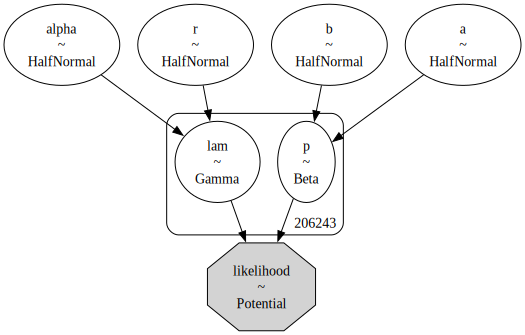

In [7]:
with pm.Model() as model_full:
    # hyper priors for the Gamma params
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    # hyper priors for the Beta params
    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)

    lam = pm.Gamma(name="lam", alpha=r, beta=alpha, shape=n)
    p = pm.Beta(name="p", alpha=a, beta=b, shape=n)

    def logp(x, t_x, T, x_zero):
        log_term_a = x * pt.log(1 - p) + x * pt.log(lam) - t_x * lam
        term_b_1 = -lam * (T - t_x)
        term_b_2 = pt.log(p) - pt.log(1 - p)
        log_term_b = pm.math.switch(
            x_zero, pm.math.logaddexp(term_b_1, term_b_2), term_b_1
        )

        return pt.sum(log_term_a) + pt.sum(log_term_b)

    likelihood = pm.Potential(
        name="likelihood",
        var=logp(x=x, t_x=t_x, T=T, x_zero=x_zero),
    )

pm.model_to_graphviz(model=model_full)

In [ ]:
with model_full:
    trace_full = pm.sample(
        draws=1_000,
        chains=4,
        target_accept=0.95,
        nuts_sampler="numpyro",
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
axes = az.plot_trace(
    data=trace_full,
    var_names=["a", "b", "alpha", "r"],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("Full BG/NBD Model Trace", fontsize=16, fontweight="bold");

## Lifetimes - BetaGeoFitter - Baseline

In [13]:
cutoff = "2023-10-01"
train_mask = transactions['DATE_KEY'] < cutoff
train_transactions = transactions[train_mask]
train_transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01
...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01


In [15]:
test_mask = ~train_mask
test_transactions = transactions[test_mask]
test_transactions = test_transactions[test_transactions['COHORT'].isin(train_transactions['COHORT'].unique())]
test_transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
32,1007485517881.0,4883147096204,2024-06-27,2024-06-27 10:26:09,152.00,2024-06-24,2024-06-01,2021-05-01
33,1007485517881.0,4941014040716,2024-08-15,2024-08-15 10:07:28,211.48,2024-08-12,2024-08-01,2021-05-01
70,1018871054393.0,4802552299660,2024-04-12,2024-04-12 16:44:57,167.00,2024-04-08,2024-04-01,2021-05-01
83,1019920908345.0,4722035458188,2024-01-25,2024-01-25 09:33:34,226.80,2024-01-22,2024-01-01,2021-06-01
84,1019920908345.0,4749032882316,2024-02-23,2024-02-23 08:34:25,11.00,2024-02-19,2024-02-01,2021-06-01
...,...,...,...,...,...,...,...,...
633636,992679788601.0,4949602762892,2024-08-23,2024-08-23 19:18:41,69.95,2024-08-19,2024-08-01,2021-06-01
633665,998212173881.0,4969169420428,2024-09-10,2024-09-10 10:12:29,0.00,2024-09-09,2024-09-01,2021-09-01
633667,998809370681.0,4962189049996,2024-09-03,2024-09-03 22:35:05,248.38,2024-09-02,2024-09-01,2022-11-01
633668,998809370681.0,4962245116044,2024-09-03,2024-09-03 23:35:12,39.15,2024-09-02,2024-09-01,2022-11-01


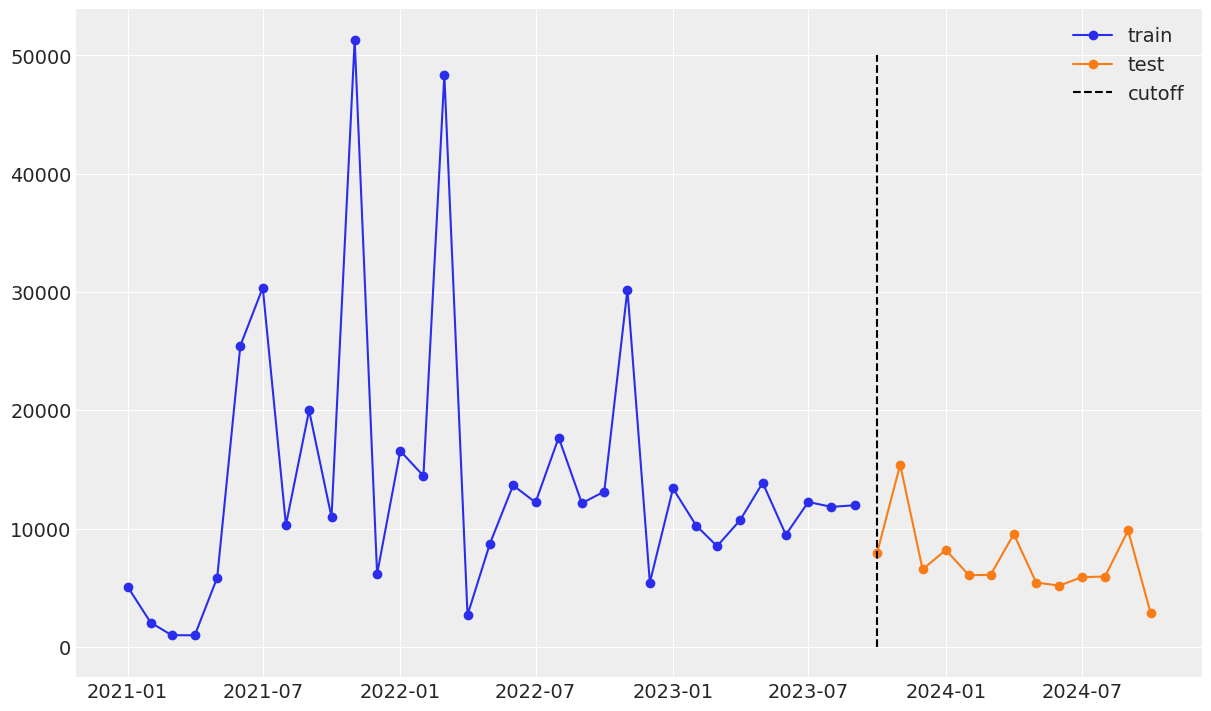

In [23]:
plt.plot(
    train_transactions.groupby(['MONTH'])['ORDER_KEY'].count(),
    label = "train",
    marker = 'o'
)

plt.plot(
    test_transactions.groupby(['MONTH'])['ORDER_KEY'].count(),
    label = "test",
    marker = 'o'
)

plt.vlines(
    x = np.datetime64(cutoff), ymin = 0, ymax = 50000,
    linestyles="--",
    colors = "black",
    label = "cutoff"
)

plt.legend()
plt.show()

In [24]:
rfm_train = rfm_summary(
    train_transactions, 
    customer_id_col="CUSTOMER_KEY",
    datetime_col="DATE_KEY",
    monetary_value_col="FULL_REVENUE",
    time_unit = "D",
)

bgf = BetaGeoFitter()
bgf.fit(
    frequency = rfm_train['frequency'].to_numpy(), 
    recency = rfm_train['recency'].to_numpy(), 
    T = rfm_train['T'].to_numpy()
)
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.246160,0.001402,0.243413,0.248908
alpha,46.224285,0.442711,45.356572,47.091997
a,0.602325,0.010638,0.581476,0.623175
b,1.934521,0.046683,1.843022,2.026020


In [25]:
for num_months in [3, 6, 12]:
    rfm_train[f'predicted purchases up to {num_months}'] = bgf.conditional_expected_number_of_purchases_up_to_time(
        num_months, 
        rfm_train['frequency'], rfm_train['recency'], rfm_train['T']
    )

rfm_train

,customer_id,frequency,recency,T,monetary_value,predicted purchases up to 3,predicted purchases up to 6,predicted purchases up to 12
0,1.01691637690413e+19,0.0,0.0,690.0,0.000000,0.001002,0.002004,0.004003
1,1.0180262201447422e+19,0.0,0.0,676.0,0.000000,0.001022,0.002043,0.004080
2,1.0334292439570778e+19,0.0,0.0,467.0,0.000000,0.001438,0.002873,0.005736
3,1.1021537414442353e+19,0.0,0.0,297.0,0.000000,0.002149,0.004292,0.008562
4,1.1460252927270205e+19,0.0,0.0,719.0,0.000000,0.000964,0.001928,0.003851
...,...,...,...,...,...,...,...,...
163597,997118640185.0,1.0,557.0,796.0,90.000000,0.003014,0.006023,0.012030
163598,997525913657.0,0.0,0.0,673.0,0.000000,0.001026,0.002051,0.004097
163599,998212173881.0,1.0,247.0,733.0,0.000000,0.002336,0.004668,0.009323
163600,998809370681.0,0.0,0.0,306.0,0.000000,0.002094,0.004183,0.008345


In [26]:
test_transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
32,1007485517881.0,4883147096204,2024-06-27,2024-06-27 10:26:09,152.00,2024-06-24,2024-06-01,2021-05-01
33,1007485517881.0,4941014040716,2024-08-15,2024-08-15 10:07:28,211.48,2024-08-12,2024-08-01,2021-05-01
70,1018871054393.0,4802552299660,2024-04-12,2024-04-12 16:44:57,167.00,2024-04-08,2024-04-01,2021-05-01
83,1019920908345.0,4722035458188,2024-01-25,2024-01-25 09:33:34,226.80,2024-01-22,2024-01-01,2021-06-01
84,1019920908345.0,4749032882316,2024-02-23,2024-02-23 08:34:25,11.00,2024-02-19,2024-02-01,2021-06-01
...,...,...,...,...,...,...,...,...
633636,992679788601.0,4949602762892,2024-08-23,2024-08-23 19:18:41,69.95,2024-08-19,2024-08-01,2021-06-01
633665,998212173881.0,4969169420428,2024-09-10,2024-09-10 10:12:29,0.00,2024-09-09,2024-09-01,2021-09-01
633667,998809370681.0,4962189049996,2024-09-03,2024-09-03 22:35:05,248.38,2024-09-02,2024-09-01,2022-11-01
633668,998809370681.0,4962245116044,2024-09-03,2024-09-03 23:35:12,39.15,2024-09-02,2024-09-01,2022-11-01


In [30]:
test_transactions['DATE_KEY'].isin(pd.date_range(
    np.datetime64(cutoff),
    np.datetime64(cutoff) + pd.DateOffset(months = 3)
)) * test_transactions

32        False
33        False
70        False
83        False
84        False
          ...  
633636    False
633665    False
633667    False
633668    False
633669    False
Name: DATE_KEY, Length: 94842, dtype: bool

NOTE: we did not finish running this to completion because it was taking too long

In [ ]:
for num_months in [3, 6, 12]:
    period_end = np.datetime64(cutoff) + pd.DateOffset(months = num_months)
    period = pd.date_range(
        np.datetime64(cutoff),
        period_end
    )
    for i in rfm_train.index:
        print(f"Processing row {i}", end= "\r")

        rfm_train.loc[i, f"actual purchases up to {num_months}"] = (
            (test_transactions['DATE_KEY'].isin(period)) * 
            (test_transactions['CUSTOMER_KEY'] == rfm_train.loc[i, "customer_id"] )
        ).sum()

rfm_train

In [ ]:
date_range = pd.date_range(
    "2021-06-01",
    "2024-10-01",
    freq = "4M"
)

for cutoff in date_range:

## Bayesian Model - Randomly Chosen Individual

In [5]:
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01
...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01


In [7]:
cutoff = "2023-10-01"
train_mask = transactions['DATE_KEY'] < cutoff
train_transactions = transactions[train_mask]
train_transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01
...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01


In [8]:
test_mask = ~train_mask
test_transactions = transactions[test_mask]
test_transactions = test_transactions[test_transactions['COHORT'].isin(train_transactions['COHORT'].unique())]
test_transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
32,1007485517881.0,4883147096204,2024-06-27,2024-06-27 10:26:09,152.00,2024-06-24,2024-06-01,2021-05-01
33,1007485517881.0,4941014040716,2024-08-15,2024-08-15 10:07:28,211.48,2024-08-12,2024-08-01,2021-05-01
70,1018871054393.0,4802552299660,2024-04-12,2024-04-12 16:44:57,167.00,2024-04-08,2024-04-01,2021-05-01
83,1019920908345.0,4722035458188,2024-01-25,2024-01-25 09:33:34,226.80,2024-01-22,2024-01-01,2021-06-01
84,1019920908345.0,4749032882316,2024-02-23,2024-02-23 08:34:25,11.00,2024-02-19,2024-02-01,2021-06-01
...,...,...,...,...,...,...,...,...
633636,992679788601.0,4949602762892,2024-08-23,2024-08-23 19:18:41,69.95,2024-08-19,2024-08-01,2021-06-01
633665,998212173881.0,4969169420428,2024-09-10,2024-09-10 10:12:29,0.00,2024-09-09,2024-09-01,2021-09-01
633667,998809370681.0,4962189049996,2024-09-03,2024-09-03 22:35:05,248.38,2024-09-02,2024-09-01,2022-11-01
633668,998809370681.0,4962245116044,2024-09-03,2024-09-03 23:35:12,39.15,2024-09-02,2024-09-01,2022-11-01


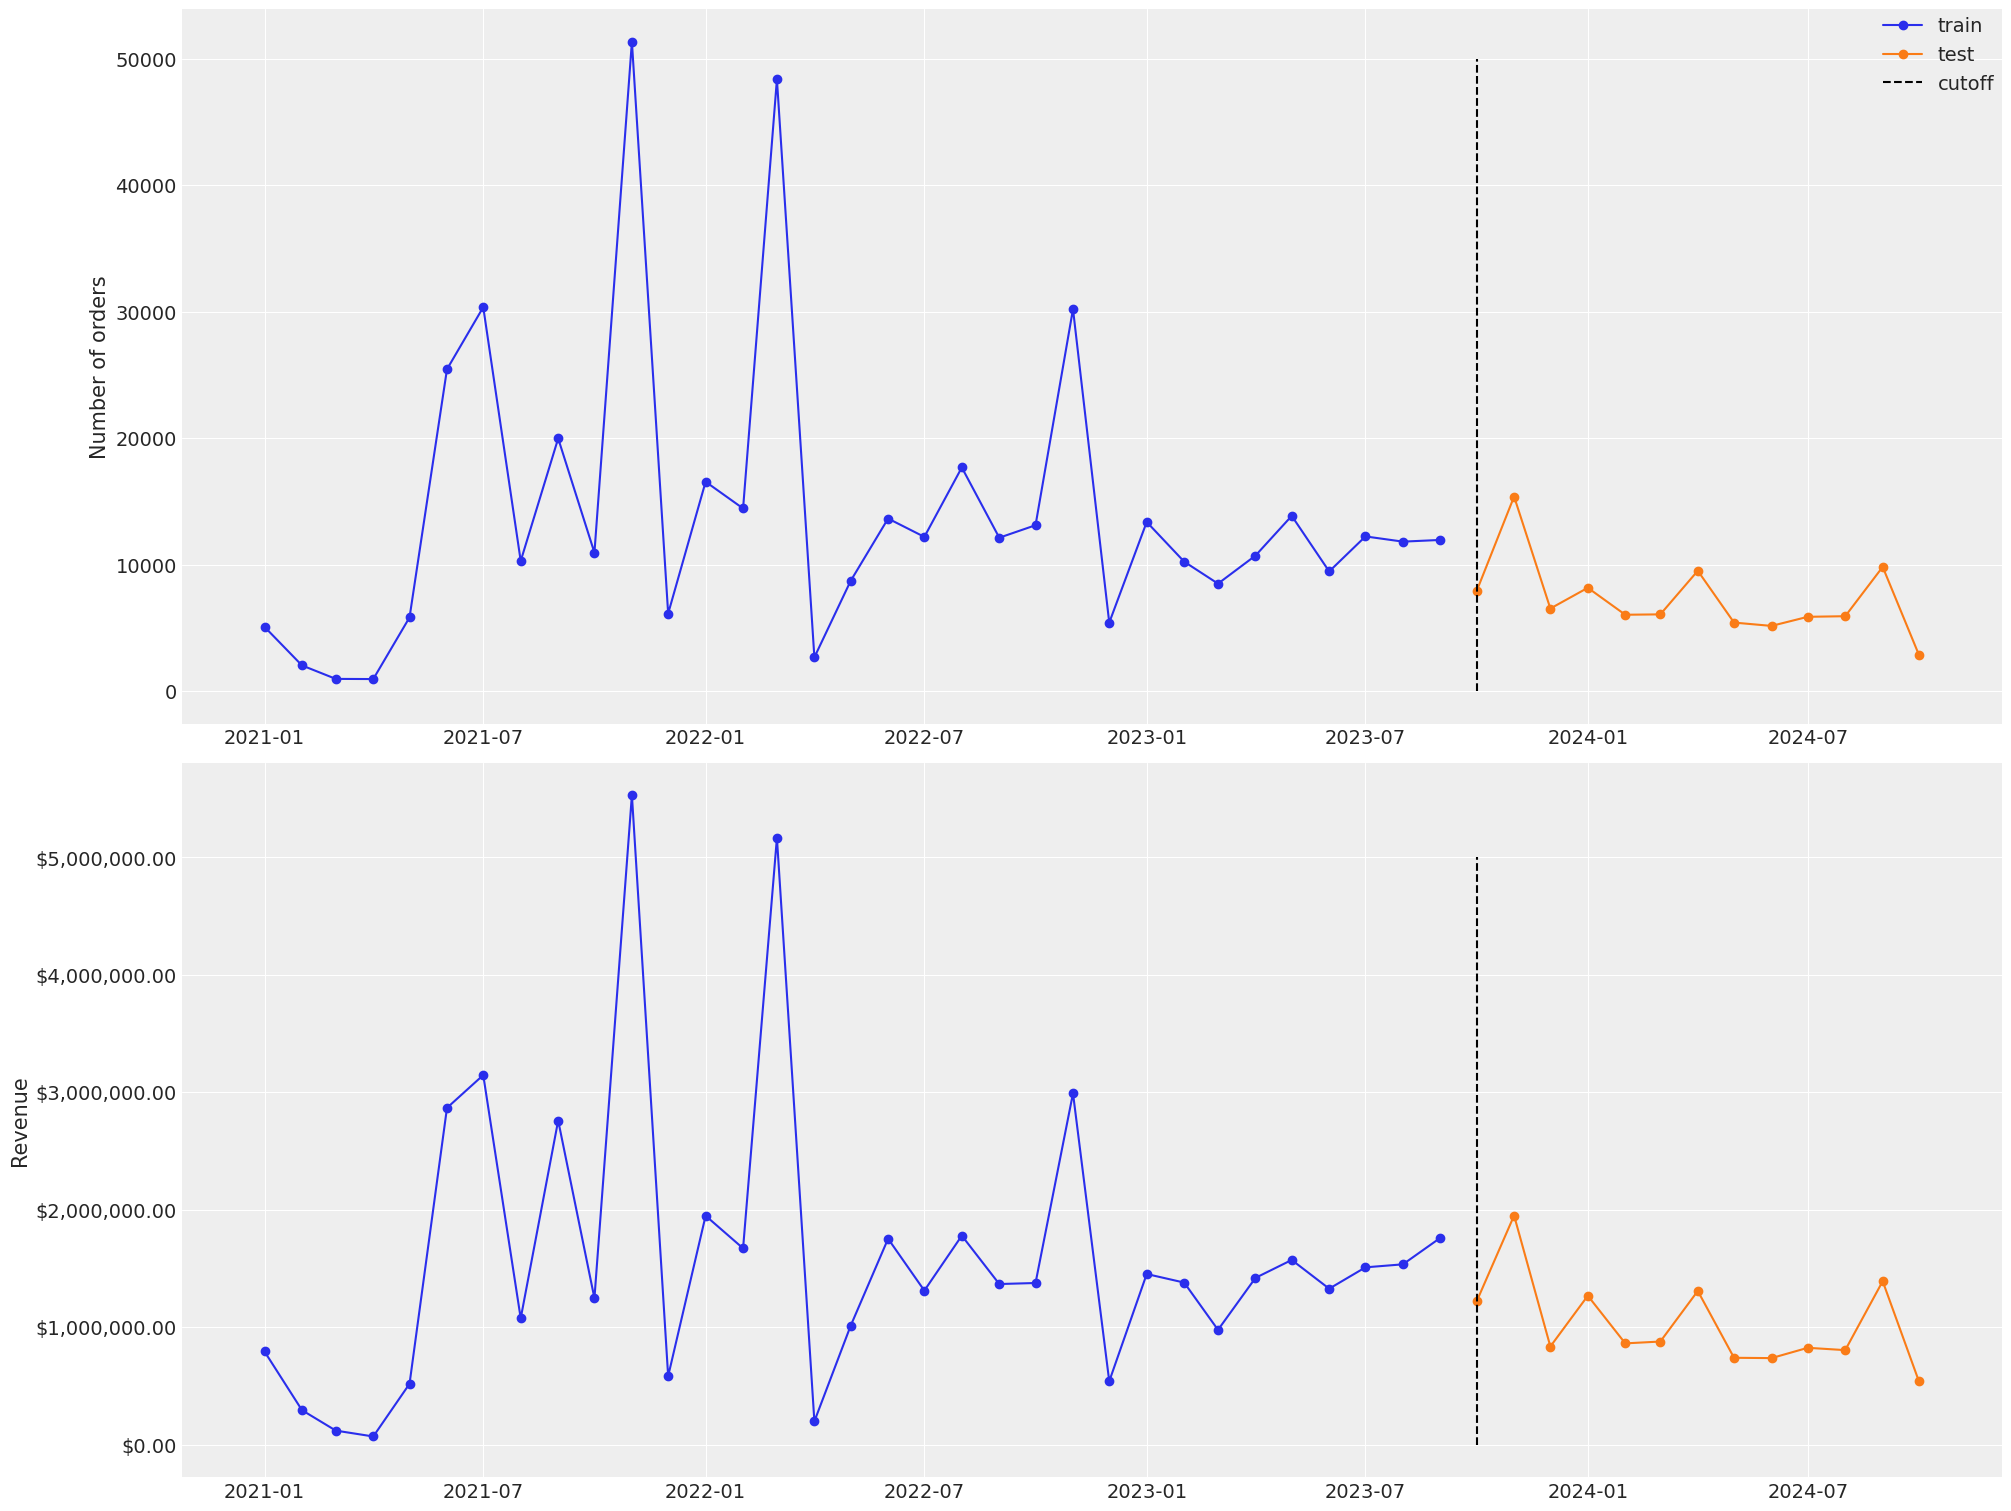

In [9]:
fig, axes = plt.subplots(2, 1, figsize = (20, 15))
axes[0].plot(
    train_transactions.groupby(['MONTH'])['ORDER_KEY'].count(),
    label = "train",
    marker = 'o'
)

axes[0].plot(
    test_transactions.groupby(['MONTH'])['ORDER_KEY'].count(),
    label = "test",
    marker = 'o'
)

axes[0].vlines(
    x = np.datetime64(cutoff), ymin = 0, ymax = 50000,
    linestyles="--",
    colors = "black",
    label = "cutoff"
)

axes[0].set_ylabel("Number of orders")

axes[1].plot(
    train_transactions.groupby(['MONTH'])['FULL_REVENUE'].sum(),
    marker = 'o'
)

axes[1].plot(
    test_transactions.groupby(['MONTH'])['FULL_REVENUE'].sum(),
    marker = 'o'
)

axes[1].vlines(
    x = np.datetime64(cutoff), ymin = 0, ymax = 5e6,
    linestyles="--",
    colors = "black",
)
axes[1].set_ylabel("Revenue")

axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.2f}"))
fig.legend()
plt.show()

In [10]:
rfm_train = rfm_summary(
    train_transactions,
    customer_id_col="CUSTOMER_KEY",
    datetime_col="DATE_KEY",
    monetary_value_col="FULL_REVENUE",
    time_unit = "D",
)

rfm_train

,customer_id,frequency,recency,T,monetary_value
0,1.01691637690413e+19,0.0,0.0,690.0,0.000000
1,1.0180262201447422e+19,0.0,0.0,676.0,0.000000
2,1.0334292439570778e+19,0.0,0.0,467.0,0.000000
3,1.1021537414442353e+19,0.0,0.0,297.0,0.000000
4,1.1460252927270205e+19,0.0,0.0,719.0,0.000000
...,...,...,...,...,...
163597,997118640185.0,1.0,557.0,796.0,90.000000
163598,997525913657.0,0.0,0.0,673.0,0.000000
163599,998212173881.0,1.0,247.0,733.0,0.000000
163600,998809370681.0,0.0,0.0,306.0,0.000000


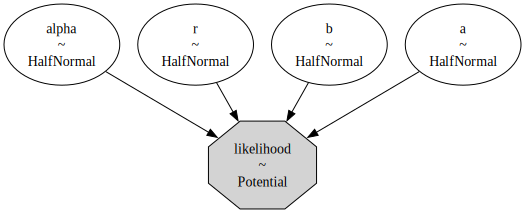

In [11]:
with pm.Model() as model:
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)

    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)

    def logp(x, t_x, T, x_zero):
        a1 = pt.gammaln(r + x) - pt.gammaln(r) + r * pt.log(alpha)
        a2 = (
            pt.gammaln(a + b)
            + pt.gammaln(b + x)
            - pt.gammaln(b)
            - pt.gammaln(a + b + x)
        )
        a3 = -(r + x) * pt.log(alpha + T)
        a4 = (
            pt.log(a) - pt.log(b + pt.maximum(x, 1) - 1) - (r + x) * pt.log(t_x + alpha)
        )
        max_a3_a4 = pt.maximum(a3, a4)
        ll_1 = a1 + a2
        ll_2 = (
            pt.log(
                pt.exp(a3 - max_a3_a4)
                + pt.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)
            )
            + max_a3_a4
        )
        return pt.sum(ll_1 + ll_2)

    likelihood = pm.Potential(
        name="likelihood",
        var=logp(
            x=rfm_train['frequency'].to_numpy(), 
            t_x=rfm_train['recency'].to_numpy(), 
            T=rfm_train['T'].to_numpy(), 
            x_zero= np.vectorize(int)(rfm_train['frequency'] > 0)
        ),
    )

pm.model_to_graphviz(model=model)

In [12]:
with model:
    trace = pm.sample(
        tune=500,
        draws=1_000,
        chains=4,
        target_accept=0.95,
        nuts_sampler="numpyro",
    )

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [14]:
bgf = BetaGeoFitter()
bgf.fit(
    frequency = rfm_train['frequency'].to_numpy(),
    recency = rfm_train['recency'].to_numpy(),
    T = rfm_train['T'].to_numpy(),
)

<lifetimes.BetaGeoFitter: fitted with 163602 subjects, a: 0.60, alpha: 46.22, b: 1.93, r: 0.25>

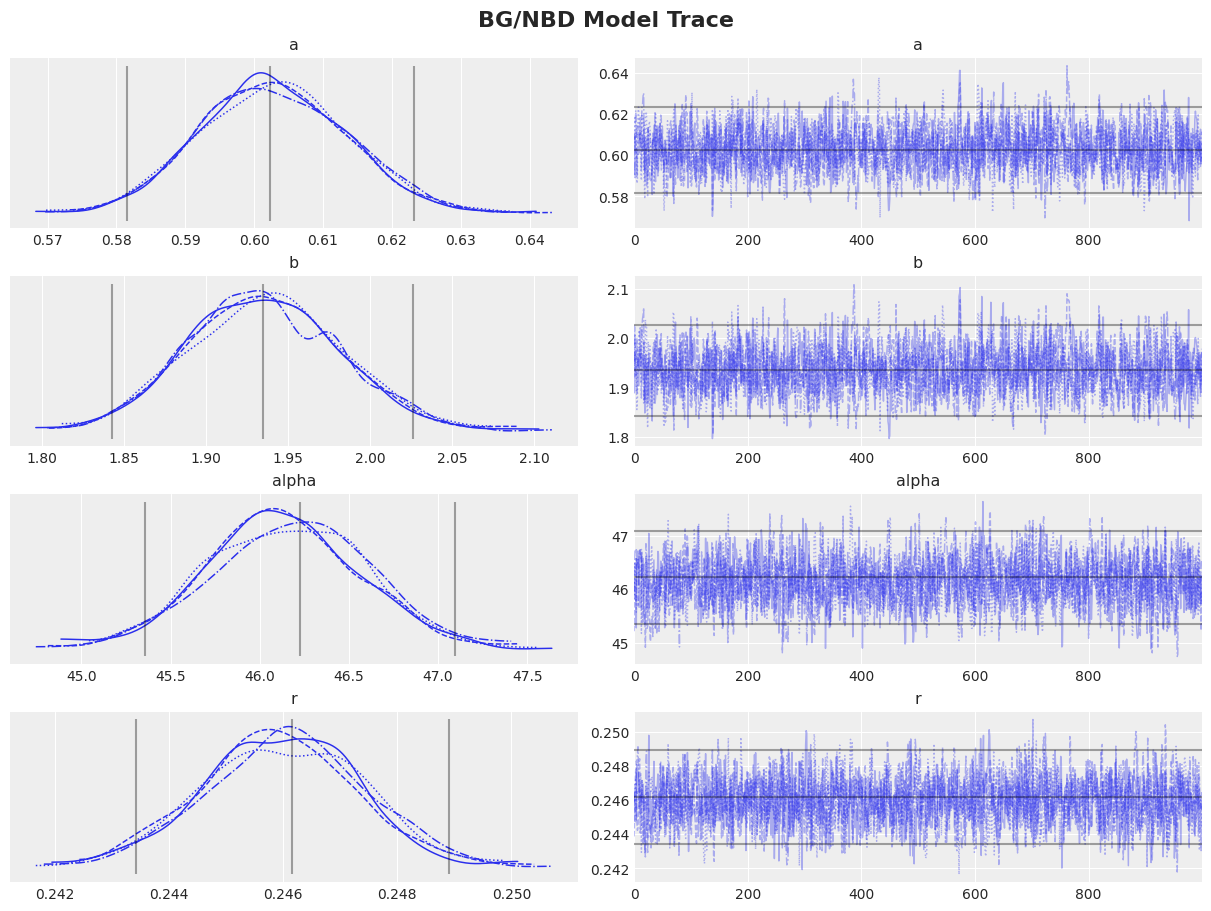

In [15]:
axes = az.plot_trace(
    data=trace,
    lines=[
        (k, {}, [v.to_numpy()])
        for k, v in bgf.summary[
            ["coef", "lower 95% bound", "upper 95% bound"]
        ].T.items()
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBD Model Trace", fontsize=16, fontweight="bold");

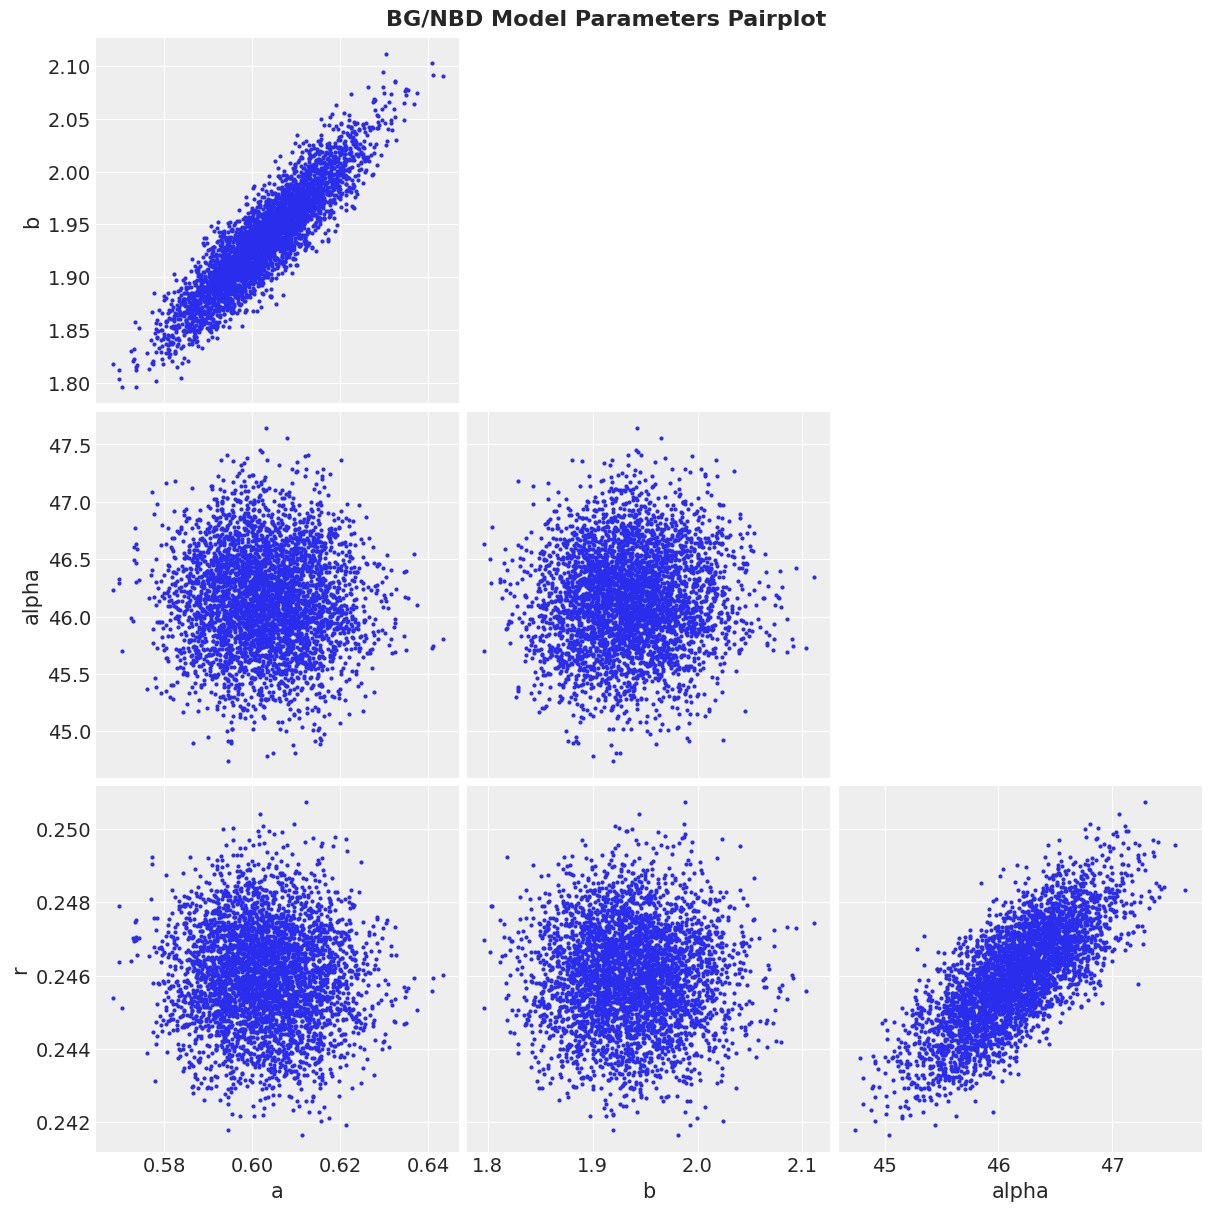

In [20]:
axes = az.plot_pair(data=trace, var_names=["a", "b", "alpha", "r"], figsize=(12, 12))
fig = axes[0][0].get_figure()
fig.suptitle("BG/NBD Model Parameters Pairplot", fontsize=16, fontweight="bold");

We do not observe that $a$ and $b$ are highly correlated.

In [19]:
az.summary(data=trace, var_names=["a", "b", "alpha", "r"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.603,0.011,0.584,0.624,0.000,0.000,1684.0,1925.0,1.0
b,1.936,0.047,1.852,2.024,0.001,0.001,1624.0,2028.0,1.0
alpha,46.145,0.435,45.268,46.902,0.010,0.007,1850.0,2165.0,1.0
r,0.246,0.001,0.243,0.248,0.000,0.000,1831.0,2135.0,1.0


In [28]:
def _sample(array, n_samples):
    idx = np.random.default_rng(42).choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

def conditional_expected_number_of_purchases_up_to_time(t, trace, x, t_x, T):
    n_vals = x.shape[0]
    a     = _sample(array=trace.posterior["a"].to_numpy(), n_samples=n_vals)
    b     = _sample(array=trace.posterior["b"].to_numpy(), n_samples=n_vals)
    alpha = _sample(array=trace.posterior["alpha"].to_numpy(), n_samples=n_vals)
    r     = _sample(array=trace.posterior["r"].to_numpy(), n_samples=n_vals)

    _a = r + x[..., None]
    _b = b + x[..., None]
    _c = a + b + x[..., None] - 1
    _z = t / (alpha + T[..., None] + t)
    ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))

    ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + (
        _c - _a - _b
    ) * np.log(1 - _z)
    ln_hyp_term = np.where(np.isinf(ln_hyp_term), ln_hyp_term_alt, ln_hyp_term)
    first_term = (a + b + x[..., None] - 1) / (a - 1)
    second_term = 1 - np.exp(
        ln_hyp_term
        + (r + x[..., None])
        * np.log((alpha + T[..., None]) / (alpha + t + T[..., None]))
    )

    numerator = first_term * second_term
    denominator = 1 + (x > 0)[..., None] * (a / (b + x[..., None] - 1)) * (
        (alpha + T[..., None]) / (alpha + t_x[..., None])
    ) ** (r + x[..., None])

    return numerator / denominator


# generate posterior samples
t = 90
conditional_expected_number_of_purchases_up_to_time_samples = (
    conditional_expected_number_of_purchases_up_to_time(
        t, 
        trace, 
        rfm_train['frequency'].to_numpy(), 
        rfm_train['recency'].to_numpy(), 
        rfm_train['T'].to_numpy()
    )
)

In [31]:
conditional_expected_number_of_purchases_up_to_time_samples.shape

(163602, 1000)

In [30]:
rfm_train

,customer_id,frequency,recency,T,monetary_value
0,1.01691637690413e+19,0.0,0.0,690.0,0.000000
1,1.0180262201447422e+19,0.0,0.0,676.0,0.000000
2,1.0334292439570778e+19,0.0,0.0,467.0,0.000000
3,1.1021537414442353e+19,0.0,0.0,297.0,0.000000
4,1.1460252927270205e+19,0.0,0.0,719.0,0.000000
...,...,...,...,...,...
163597,997118640185.0,1.0,557.0,796.0,90.000000
163598,997525913657.0,0.0,0.0,673.0,0.000000
163599,998212173881.0,1.0,247.0,733.0,0.000000
163600,998809370681.0,0.0,0.0,306.0,0.000000


In [ ]:
rfm_train['expected_3_months_order_count_mean'] = conditional_expected_number_of_purchases_up_to_time_samples.mean(axis = 1)


,customer_id,frequency,recency,T,monetary_value,expected_3_months_order_count_mean
0,1.01691637690413e+19,0.0,0.0,690.0,0.000000,0.029546
1,1.0180262201447422e+19,0.0,0.0,676.0,0.000000,0.030125
2,1.0334292439570778e+19,0.0,0.0,467.0,0.000000,0.042073
3,1.1021537414442353e+19,0.0,0.0,297.0,0.000000,0.062216
4,1.1460252927270205e+19,0.0,0.0,719.0,0.000000,0.028451
...,...,...,...,...,...,...
163597,997118640185.0,1.0,557.0,796.0,90.000000,0.088703
163598,997525913657.0,0.0,0.0,673.0,0.000000,0.030228
163599,998212173881.0,1.0,247.0,733.0,0.000000,0.068619
163600,998809370681.0,0.0,0.0,306.0,0.000000,0.060659


In [36]:
for n_months in [3, 6, 12]:
    rfm_train[f"expected_{n_months}_order_count"] = conditional_expected_number_of_purchases_up_to_time(
        n_months * 31, 
        trace, 
        rfm_train['frequency'].to_numpy(), 
        rfm_train['recency'].to_numpy(), 
        rfm_train['T'].to_numpy()
    ).mean(axis = 1)

rfm_train

,customer_id,frequency,recency,T,monetary_value,expected_3_months_order_count_mean,expected_3_order_count,expected_6_order_count,expected_9_order_count
0,1.01691637690413e+19,0.0,0.0,690.0,0.000000,0.029546,0.030513,0.059996,0.088558
1,1.0180262201447422e+19,0.0,0.0,676.0,0.000000,0.030125,0.031111,0.061153,0.090240
2,1.0334292439570778e+19,0.0,0.0,467.0,0.000000,0.042073,0.043441,0.084861,0.124545
3,1.1021537414442353e+19,0.0,0.0,297.0,0.000000,0.062216,0.064216,0.124233,0.180841
4,1.1460252927270205e+19,0.0,0.0,719.0,0.000000,0.028451,0.029383,0.057809,0.085376
...,...,...,...,...,...,...,...,...,...
163597,997118640185.0,1.0,557.0,796.0,90.000000,0.088703,0.091601,0.179696,0.264655
163598,997525913657.0,0.0,0.0,673.0,0.000000,0.030228,0.031218,0.061360,0.090541
163599,998212173881.0,1.0,247.0,733.0,0.000000,0.068619,0.070857,0.138804,0.204167
163600,998809370681.0,0.0,0.0,306.0,0.000000,0.060659,0.062611,0.121212,0.176546


In [46]:
hdi_upper = np.apply_along_axis(
    lambda x: np.quantile(x, 0.975),
    1, 
    conditional_expected_number_of_purchases_up_to_time_samples
)

hdi_lower = np.apply_along_axis(
    lambda x: np.quantile(x, 0.025),
    1, 
    conditional_expected_number_of_purchases_up_to_time_samples
)

print(hdi_upper.shape)
print(hdi_lower.shape)
print((hdi_upper < hdi_lower).sum())

(163602,)
(163602,)
0


In [47]:
def build_model(rfm_train: pd.DataFrame):
    with pm.Model() as model:
        a = pm.HalfNormal(name="a", sigma=10)
        b = pm.HalfNormal(name="b", sigma=10)

        alpha = pm.HalfNormal(name="alpha", sigma=10)
        r = pm.HalfNormal(name="r", sigma=10)

        def logp(x, t_x, T, x_zero):
            a1 = pt.gammaln(r + x) - pt.gammaln(r) + r * pt.log(alpha)
            a2 = (
                pt.gammaln(a + b)
                + pt.gammaln(b + x)
                - pt.gammaln(b)
                - pt.gammaln(a + b + x)
            )
            a3 = -(r + x) * pt.log(alpha + T)
            a4 = (
                pt.log(a) - pt.log(b + pt.maximum(x, 1) - 1) - (r + x) * pt.log(t_x + alpha)
            )
            max_a3_a4 = pt.maximum(a3, a4)
            ll_1 = a1 + a2
            ll_2 = (
                pt.log(
                    pt.exp(a3 - max_a3_a4)
                    + pt.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)
                )
                + max_a3_a4
            )
            return pt.sum(ll_1 + ll_2)

        likelihood = pm.Potential(
            name="likelihood",
            var=logp(
                x=rfm_train['frequency'].to_numpy(), 
                t_x=rfm_train['recency'].to_numpy(), 
                T=rfm_train['T'].to_numpy(), 
                x_zero= np.vectorize(int)(rfm_train['frequency'] > 0)
            ),
        )
    return model

def fit_model():
    with model:
        trace = pm.sample(
            tune=500,
            draws=1_000,
            chains=4,
            target_accept=0.95,
            nuts_sampler="numpyro",
        )
    return trace


In [ ]:
forward_order_count = pd.DataFrame(
    columns = [
        "cutoff",
        "3 month predicted",
        "3 HDI lower",
        "3 HDI upper",
        "6 month predicted",
        "6 HDI lower",
        "6 HDI upper",
        "12 month predicted",
        "12 HDI lower",
        "12 HDI upper",
    ]
)

date_range = pd.date_range(
    start = "2024-01-01",
    end = "2024-06-01",
    freq = "4M"
)

prediction_months = [3, 6, 12]

for cutoff in date_range:
    print(f"Processing {cutoff}")
    train_mask = transactions['DATE_KEY'] < cutoff
    train_transactions = transactions[train_mask]
    train_transactions
    
    rfm_train = rfm_summary(
        train_transactions,
        customer_id_col="CUSTOMER_KEY",
        datetime_col="DATE_KEY",
        monetary_value_col="FULL_REVENUE",
        time_unit = "D",
    )

    model = build_model(rfm_train)
    trace = fit_model()

    curr_cutoff_predictions: dict = {}
    curr_cutoff_predictions['cutoff'] = cutoff

    for n_months in prediction_months:
        predicted_purchases = conditional_expected_number_of_purchases_up_to_time(
            n_months * 31, 
            trace, 
            rfm_train['frequency'].to_numpy(), 
            rfm_train['recency'].to_numpy(), 
            rfm_train['T'].to_numpy()
        )
        curr_cutoff_predictions[f"{n_months} month predicted"] = [(
            predicted_purchases
            .mean(axis=1)
            .sum()
        )]
        curr_cutoff_predictions[f"{n_months} HDI upper"] = [(
            np.apply_along_axis(
                lambda x: np.quantile(x, 0.975),
                1,
                predicted_purchases
            ).sum()
        )]
        curr_cutoff_predictions[f"{n_months} HDI lower"] = [(
            np.apply_along_axis(
                lambda x: np.quantile(x, 0.025),
                1,
                predicted_purchases
            ).sum()
        )]
    
    forward_order_count = pd.concat(
        [
            forward_order_count,
            pd.DataFrame(curr_cutoff_predictions)
        ],
        ignore_index=True
    )

Processing 2024-01-31 00:00:00


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Processing 2024-05-31 00:00:00


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [72]:
for n_month in prediction_months:
    forward_order_count[f"{n_month} actual"] = [np.nan for _ in range(forward_order_count.shape[0])]

for i in range(forward_order_count.shape[0]):
    cutoff = forward_order_count.loc[i, "cutoff"]

    train_mask = transactions['DATE_KEY'] < cutoff
    train_transactions = transactions[train_mask]
    test_mask = ~train_mask
    test_transactions = transactions[test_mask]
    test_transactions = test_transactions[test_transactions['COHORT'].isin(train_transactions['COHORT'].unique())]

    for n_month in prediction_months:
        period = pd.date_range(
            start = cutoff,
            end = cutoff + pd.DateOffset(days = n_month * 31),
            freq = "1D"
        )

        if (cutoff + pd.DateOffset(days = n_months * 31)) <= test_transactions['DATE_KEY'].max():
            print(f"Processing {n_month} at cutoff: {cutoff}")
            forward_order_count.loc[i, f"{n_month} actual"] = test_transactions['DATE_KEY'].isin(period).sum()
    

Processing 3 at cutoff: 2024-01-31 00:00:00
Processing 6 at cutoff: 2024-01-31 00:00:00
Processing 12 at cutoff: 2024-01-31 00:00:00
Processing 3 at cutoff: 2024-05-31 00:00:00
Processing 6 at cutoff: 2024-05-31 00:00:00
Processing 12 at cutoff: 2024-05-31 00:00:00


In [73]:
df = forward_order_count[[
    '3 predicted',
    '3 HDI lower',
    '3 HDI upper',
    '3 actual',
    '6 predicted',
    '6 HDI lower',
    '6 HDI upper',
    '6 actual',
    '12 predicted',
    '12 HDI lower',
    '12 HDI upper',
    '12 actual',
]]

df

,3 predicted,3 HDI lower,3 HDI upper,3 actual,6 predicted,6 HDI lower,6 HDI upper,6 actual,12 predicted,12 HDI lower,12 HDI upper,12 actual
0,31407.432510,31215.100237,31601.435178,25735.0,60320.804603,59924.289025,60720.825043,44846.0,113050.270256,112209.069738,113899.176330,65354.0
1,30200.457481,30018.503776,30380.157897,22546.0,58034.795730,57660.138168,58403.778756,38091.0,108831.426871,108038.262670,109612.159451,38091.0


We see that the prediction here fails to capture the observed number of purchases.

## Time varying covariates

In [40]:
np.random.seed(42)

# construct covariate
mu = 0.4
rho = 0.7

x = rfm_train['frequency'].to_numpy()
t_x = rfm_train['recency'].to_numpy()
T = rfm_train['T'].to_numpy()

z = np.random.default_rng(42).binomial(n=1, p=mu, size=x.size)
# change frequency values by reducing it the values where z !=0
x_z = np.floor(x * (1 - (rho * z)))
# make sure the recency is zero whenever the frequency is zero
t_x_z = t_x.copy()
t_x_z[np.argwhere(x_z == 0).flatten()] = 0
# sanity checks
assert x_z.min() == 0
assert np.all(t_x_z[np.argwhere(x_z == 0).flatten()] == 0)
# convenient indicator function
int_vec = np.vectorize(int)
x_zero_z = int_vec(x_z > 0)

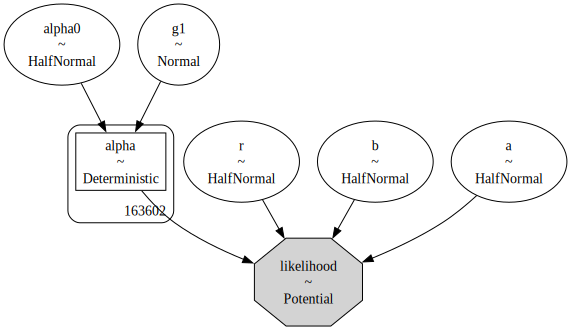

In [41]:
with pm.Model() as model_cov:
    # a0 = pm.HalfNormal(name="a0", sigma=10)
    # g2 = pm.Normal(name="g2", mu=0, sigma=10)
    # a = a0 * tt.exp(g2 * z)
    a = pm.HalfNormal(name="a", sigma=10)

    # b0 = pm.HalfNormal(name="b0", sigma=10)
    # g3 = pm.Normal(name="g3", mu=0, sigma=10)
    # b = tt.exp(g3 * z)
    b = pm.HalfNormal(name="b", sigma=10)

    alpha0 = pm.HalfNormal(name="alpha0", sigma=10)
    g1 = pm.Normal(name="g1", mu=0, sigma=10)
    alpha = pm.Deterministic(name="alpha", var=alpha0 * pt.exp(-g1 * z))

    r = pm.HalfNormal(name="r", sigma=10)

    def logp(x, t_x, T, x_zero):
        a1 = pt.gammaln(r + x) - pt.gammaln(r) + r * pt.log(alpha)
        a2 = (
            pt.gammaln(a + b)
            + pt.gammaln(b + x)
            - pt.gammaln(b)
            - pt.gammaln(a + b + x)
        )
        a3 = -(r + x) * pt.log(alpha + T)
        a4 = (
            pt.log(a) - pt.log(b + pt.maximum(x, 1) - 1) - (r + x) * pt.log(t_x + alpha)
        )
        max_a3_a4 = pt.maximum(a3, a4)
        ll_1 = a1 + a2
        ll_2 = (
            pt.log(
                pt.exp(a3 - max_a3_a4)
                + pt.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)
            )
            + max_a3_a4
        )
        return pt.sum(ll_1 + ll_2)

    likelihood = pm.Potential(
        name="likelihood",
        var=logp(
            x=x_z, 
            t_x=t_x_z, 
            T=T, 
            x_zero=x_zero_z),
    )

pm.model_to_graphviz(model=model_cov)

In [42]:
with model_cov:
    trace_cov = pm.sample(
        tune=500,
        draws=1_000,
        chains=4,
        target_accept=0.95,
        nuts_sampler="numpyro",
    )

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]